# BioCreative II Gene Mention (GM) Task

For more information: https://biocreative.bioinformatics.udel.edu/tasks/biocreative-ii/task-1a-gene-mention-tagging/

## Training Data

The training data is described in the corpus README.GM file, but I'll describe it here as well. Training data consists of a sentences file `train.in` and a label file `GENE.eval`. The eval file lists the offsets of any gene mentions (there may be none for any sentence). It is easiest to understand using an example using the first sentence from `train.in`:

```
P00001606T0076 Comparison with alkaline phosphatases and 5-nucleotidase
```
Each line contains a single sentence, starting with a unique sentence identifier, followed by the text. This particular sample contains two (2) gene mentions, listed on two lines in the `GENE.eval` file:

```
P00001606T0076|14 33|alkaline phosphatases
P00001606T0076|37 50|5-nucleotidase
```
The first field (delimited by the bar symbols) is the matching sentence ID. The second field contains the offset of the first and last characters in the GM, _not counting space characters_. So, looking at _alkaline phosphatases_, the first letter `a` is at offset 14 keeping in mind that the first character in the sentence is offset 0. If you are not careful, you may think the offset of `a` is 16, but remember that spaces are not counted. Counting in a similar way, the last `s` in _phosphatases_ is at offset 33.

## Prepare the training data

This format is not very convenient for training our ML model. One method used to train NER systems is to label each sentence token with either 'B','I', or 'O' where 'B' marks the beginning token in an entity, 'I' marks subsequent tokens in a multi-token entity (*inside*), and 'O' is for tokens *outside* the entity. For this example, we will use a Keras model to perform _sequence tagging_, where the tags are 'B', 'I', and 'O'. This is very similar to how one would perform full NER or POS tagging.

The module *bc2reader.py* is provided to help convert these two files to something more usable. The first argument to the `BC2Reader` contructor is the sentence file. The second is the gene mention file.


In [99]:
from bc2reader import BC2Reader
import os

train_home = '/home/ryan/Development/deep-learn-bio-nlp/bc2/bc2geneMention/train'
reader = BC2Reader('{0}/train.in'.format(train_home), '{0}/GENE.eval'.format(train_home))
reader.convert('{0}/train.json'.format(train_home))
# vocab = [a for a, b in reader.vocab.items() if b >= 3] # Let's see the word at least 3 times
vocab = [a for a, _ in reader.vocab.items()] 

In [100]:
print("Size of vocabulary: {0}".format(len(vocab)))

Size of vocabulary: 36655


This will generate a JSON file with a more familiar format. Here is the first sentence in our BIO format:

In [101]:
import json
with open('{0}/train.json'.format(train_home), 'r') as json_file:
    training_data = json.load(json_file)
    print(training_data[0])

['P00001606T0076', ['Comparison', 'with', 'alkaline', 'phosphatases', 'and', '5-nucleotidase'], ['O', 'O', 'B', 'I', 'O', 'B']]


This may be easier to read if we zip together the tokens and labels:

In [102]:
print(list(zip(training_data[0][1], training_data[0][2])))

[('Comparison', 'O'), ('with', 'O'), ('alkaline', 'B'), ('phosphatases', 'I'), ('and', 'O'), ('5-nucleotidase', 'B')]


## Prepare the test data

The same _bc2reader_ is used to format the test file.

In [103]:
test_home = '/home/ryan/Development/deep-learn-bio-nlp/bc2/bc2GNandGMgold_Subs/sourceforgeDistrib-22-Sept-07/genemention/BC2GM/test'
reader = BC2Reader('{0}/test.in'.format(test_home), '{0}/GENE.eval'.format(test_home))
reader.convert('{0}/test.json'.format(test_home))

with open('{0}/test.json'.format(test_home), 'r') as json_file:
    test_data = json.load(json_file)
    print(test_data[0])

['BC2GM000008491', ['Phenotypic', 'analysis', 'demonstrates', 'that', 'trio', 'and', 'Abl', 'cooperate', 'in', 'regulating', 'axon', 'outgrowth', 'in', 'the', 'embryonic', 'central', 'nervous', 'system', '(', 'CNS', ')', '.'], ['O', 'O', 'O', 'O', 'B', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']]


## Setup the model constants

0: 90.33062421615003
1: 4.387337922044577
2: 5.282037861805398


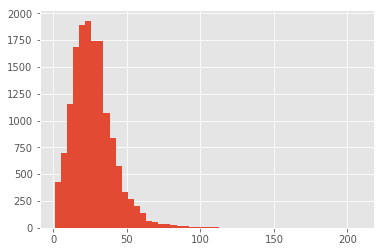

In [104]:
import numpy as np
from collections import Counter
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, GRU, ConvLSTM2D
from keras.layers import TimeDistributed, Dropout, Bidirectional

max_len = 150
lstm_n = 256
batch_n = 25
epoch_n = 4

word2idx = {word: idx + 2 for idx, word in enumerate(vocab)}
word2idx['_PAD_'] = 0
word2idx['_OOV_'] = 1

tag2idx = {'O': 0, 'B': 1, 'I': 2}
n_tags = len(tag2idx)

X = [[word2idx.get(m, 1) for m in row[1]] for row in training_data]
y = [[tag2idx.get(m, 0) for m in row[2]] for row in training_data]

# Get an idea about class dist.
cnt = Counter()
for labels in y:
    cnt.update(labels)
cnt_total = sum([v for _, v in cnt.items()])
for k, v in cnt.items():
    print("{0}: {1}".format(k, (100 * v)/cnt_total))
        

# Get a general idea of the lengths of the sequences:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.hist([len(s) for s in X], bins=50)
plt.show()

X_test = [[word2idx.get(m, 1) for m in row[1]] for row in test_data]
y_test = [[tag2idx.get(m, 1) for m in row[2]] for row in test_data]

X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=word2idx['_PAD_'])
X_test = pad_sequences(maxlen=max_len, sequences=X_test, padding="post", value=word2idx['_PAD_'])
 
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx['O']) 
y = [to_categorical(i, num_classes=n_tags) for i in y]
y_test = pad_sequences(maxlen=max_len, sequences=y_test, padding="post", value=tag2idx['O']) 
y_test = [to_categorical(i, num_classes=n_tags) for i in y_test]




## Prepare the Embeddings (GloVe)

See: https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

The embeddings loaded below were learned from PMC Open Access dataset (non-commercial). This collection contains 430,944 journal articles in XML (or text) format. The XML alone is over 50GB uncompressed, so only download if you have plenty of drive space and time. Tables were filtered out since they tended to contain numeric data and not narrative text. The final cleaned text is 1,784,578,876 tokens, and 958,634 lines of text!

This first attempt at using pre-trained embeddings from biomedical journal articles didn't improve the accuracy over learning embeddings directly from the training data, but it is useful to demonstrate how these can be added to the model. Run the code below to load the pre-trained PMC embeddings. You will need to add `weights=[embedding_matrix]` and `trainable=False` as arguments to the model's Embedding layer.

### FastText version

In [105]:
import fasttext
embedding_dim = 100

fasttext_model = fasttext.load_model('./ftmodel.bin')

embedding_matrix = np.zeros((len(word2idx) + 1, embedding_dim))
for word, i in word2idx.items():
    embedding_vector = fasttext_model[word].tolist()
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Creating the model

This is the first version of the model using a single Bidirectional LSTM layer. 

In [108]:
# Borrowed heavily from 
# https://appliedmachinelearning.blog/2019/04/01/training-deep-learning-based-named-entity-recognition-from-scratch-disease-extraction-hackathon/
# as a general outline for the model...

from keras.layers.merge import add

_input = Input(shape=(max_len,))
model = Embedding(input_dim=len(word2idx) + 1, 
                  output_dim=embedding_dim, 
                  # weights=[embedding_matrix], 
                  input_length=max_len, 
                  # trainable=False, 
                  mask_zero=True)(_input)
model = Dropout(0.2)(model)
model = Bidirectional(GRU(units=lstm_n, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)
model = Model(_input, out)
 
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()



/home/ryan/anaconda3/envs/mlenv/lib/python3.7/site-packages/keras_contrib-2.0.8-py3.7.egg/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
/home/ryan/anaconda3/envs/mlenv/lib/python3.7/site-packages/keras_contrib-2.0.8-py3.7.egg/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 150)               0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 150, 100)          3665800   
_________________________________________________________________
dropout_12 (Dropout)         (None, 150, 100)          0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 150, 512)          548352    
_________________________________________________________________
time_distributed_11 (TimeDis (None, 150, 3)            1539      
_________________________________________________________________
crf_2 (CRF)                  (None, 150, 3)            27        
Total params: 4,215,718
Trainable params: 4,215,718
Non-trainable params: 0
_________________________________________________________________


### Fit the model

In [109]:
history = model.fit(X, np.array(y), batch_size=batch_n, epochs=epoch_n, validation_split=0.05, verbose=1)

Train on 14250 samples, validate on 750 samples
Epoch 1/4
14250/14250 [==============================] - 152s 11ms/step - loss: 8.6891 - crf_viterbi_accuracy: 0.8986 - val_loss: 7.2945 - val_crf_viterbi_accuracy: 0.9373
Epoch 2/4
14250/14250 [==============================] - 150s 11ms/step - loss: 8.6090 - crf_viterbi_accuracy: 0.9013 - val_loss: 7.2762 - val_crf_viterbi_accuracy: 0.9373
Epoch 3/4
14250/14250 [==============================] - 149s 10ms/step - loss: 8.5913 - crf_viterbi_accuracy: 0.9015 - val_loss: 7.2670 - val_crf_viterbi_accuracy: 0.9373
Epoch 4/4
14250/14250 [==============================] - 150s 11ms/step - loss: 8.5823 - crf_viterbi_accuracy: 0.9015 - val_loss: 7.2624 - val_crf_viterbi_accuracy: 0.9373


### Plot and review the training history

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'r+-', label='Validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'r+-', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Test set evaluation

In [110]:

pred = model.predict(X_test)
print(pred.shape)

(5000, 150, 3)


In [111]:
pred_index = np.argmax(pred, axis=-1)
print(pred_index.shape)

(5000, 150)


The following code converts the output of the tagger (where each term is BIO tagged) back to the original BCII format.

In [112]:
from collections import defaultdict

with open('{0}/ryan_eval.eval'.format(test_home), 'w') as mention_fh:
    for i, row in enumerate(test_data):
        sent_id = row[0]
        tokens = row[1][:max_len]
        running_count = 0
        buffer = {'s':None, 'e':None, 'text':[]}
        for j, token in enumerate(tokens):
            tag = pred_index[i][j]
            if tag == 1:
                buffer.get('text').append(token)
                buffer['s'] = running_count
                buffer['e'] = running_count + len(token) - 1
            elif tag == 2:
                buffer.get('text').append(token)
                buffer['e'] = running_count + len(token) - 1
            elif tag == 0 and buffer.get('s'):
                text = ' '.join(buffer.get('text'))
                mention_fh.write('{0}|{1} {2}|{3}\n'.format(sent_id, buffer.get('s'), buffer.get('e'), text))
                buffer = {'s':None, 'e':None, 'text':[]}
            running_count += len(token)

Using the BCII evaluation script, initial output on the test data is mixed (note that your output may vary). The precision is in the range of the shared task participants, but the recall leaves something to be desired -- especially the high number of false negatives (see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2559986/). 

    TP: 4142
    FP: 1008
    FN: 2189
    Precision: 0.804271844660194 Recall: 0.654241036171221 F: 0.721539935545684

This F score isn't bad, but is also isn't great. 
This score does place this system above the bottom 3 of 19 participants in the 2008 competition. Note that _only_ the training data was used (what the task describes as a _closed_ system), not using any outside resources. This is a good starting point.

One possible issue is that bio-medical journal articles have a very rich
vocabulary. This has the following effects:

* Any unseen text is likely to have a high number of OOV (unknown) words. 
* Using standard embeddings which look at complete words as input, we lose out
  on words that may have similar morphology.
  
For example, in the case of gene names, we may be missing common suffixes or 
patterns in names and/or symbols.

## Investigating sub-word embeddings
